In [ ]:
#imports

In [ ]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import os
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.express as px
from utilis import load_full_wrapped_data, create_vibe_clusters, generate_feature_trend, generate_top_10_table

In [ ]:
# Title: Generate Top 10 Songs by Year

# Description:
# Loads Spotify streaming history and converts timestamps, 
# filters data between January 1 and each year's Spotify Wrapped cutoff date, 
# groups by track name, artist, and URI, 
# calculates total play count and total minutes listened, 
# ranks songs by listening time, 
# and stores the top 10 songs for each year (2017–2024) in a dictionary.

In [ ]:

# Load streaming data ---
streaming_data = pd.read_csv('wrapped_data/streaming_data.csv')
streaming_data['ts'] = pd.to_datetime(streaming_data['ts'])

# Define wrapped end dates
wrapped_end_dates = {
    2017: "2017-10-31T23:59:59Z",
    2018: "2018-10-31T23:59:59Z",
    2019: "2019-10-31T23:59:59Z",
    2020: "2020-11-15T23:59:59Z",
    2021: "2021-11-15T23:59:59Z",
    2022: "2022-11-15T23:59:59Z",
    2023: "2023-11-15T23:59:59Z",
    2024: "2024-11-15T23:59:59Z"
}

# Create a dictionary to hold top 10 songs for each year
top_10_songs_by_year = {}

# Loop over each year
for year, end_str in wrapped_end_dates.items():
    print(f"\n🎵 Wrapped {year} – Finding Top 10 Songs by Minutes Listened")

    start = pd.Timestamp(f"{year}-01-01T00:00:00Z")
    end = pd.Timestamp(end_str)

    # Filter data for the year
    year_data = streaming_data[(streaming_data['ts'] >= start) & (streaming_data['ts'] <= end)]

    if year_data.empty:
        print(f"No data for {year}.")
        continue

    # Group by track + artist + URI
    top_songs = (
        year_data
        .groupby(['master_metadata_track_name', 'master_metadata_album_artist_name', 'spotify_track_uri'], as_index=False)
        .agg(
            total_play_count=('ts', 'count'),
            total_ms_played=('ms_played', 'sum')
        )
        .assign(
            total_minutes_played=lambda df: df['total_ms_played'] / 60000  # convert ms to minutes
        )
        .sort_values(by='total_ms_played', ascending=False)  # 🚀 MINUTES not clicks
        .head(10)  # Top 10
        .reset_index(drop=True)
        .assign(rank=lambda df: range(1, len(df) + 1))
    )

    # Store in dictionary
    top_10_songs_by_year[year] = top_songs

    # Preview
    print(top_songs[['rank', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'total_play_count', 'total_minutes_played']])



🎵 Wrapped 2017 – Finding Top 10 Songs by Minutes Listened
   rank master_metadata_track_name master_metadata_album_artist_name  \
0     1         Living In A Memory                      The Growlers   
1     2                    Someday                      The Growlers   
2     3              Late Bloomers                      The Growlers   
3     4              Still Beating                       Mac DeMarco   
4     5          Everlasting Light                    The Black Keys   
5     6            Unknown Brother                    The Black Keys   
6     7                    Trouble                 Cage The Elephant   
7     8        Take It or Leave It                 Cage The Elephant   
8     9              Threat of Joy                       The Strokes   
9    10           Trying Your Luck                       The Strokes   

   total_play_count  total_minutes_played  
0               130            347.990967  
1               139            319.295083  
2               

In [ ]:
# Title: Sample Top 50 Songs per Year with Audio Features

# Description:
# Loads streaming history and Spotify audio feature data, 
# converts timestamps and extracts years, 
# groups songs by track and artist to find the most-played tracks per year, 
# merges with Spotify audio features, 
# samples the top 50 matched songs per year (if available), 
# concatenates results into a final dataset, 
# saves to CSV, and prints a summary with key columns for EDA.


In [ ]:

# Load data
streaming_data = pd.read_csv('wrapped_data/streaming_data.csv')
spotify_features = pd.read_csv('wrapped_data/SpotifyFeatures.csv')

# Preprocess data
streaming_data['ts'] = pd.to_datetime(streaming_data['ts'])
streaming_data['year'] = streaming_data['ts'].dt.year

# Rename columns 
spotify_features = spotify_features.rename(columns={
    'track_name': 'master_metadata_track_name',
    'artist_name': 'master_metadata_album_artist_name'
})

# Prepare final storage
final_sampled_data = []

# Process year by year data
years = sorted(streaming_data['year'].dropna().unique())

for year in years:
    print(f"\n🎵 Processing year: {year}")
    
    # Get all songs for each year
    year_data = streaming_data[streaming_data['year'] == year]
    
    # Group by song and artist and count amount of plays
    top_songs = (
        year_data
        .groupby(['master_metadata_track_name', 'master_metadata_album_artist_name'], as_index=False)
        .agg(total_play_count=('ts', 'count'))
        .sort_values('total_play_count', ascending=False)
    )
    
    # Add the 'year' column 
    top_songs['year'] = year

    # Merge with SpotifyFeatures to get attributes
    merged = top_songs.merge(
        spotify_features,
        on=['master_metadata_track_name', 'master_metadata_album_artist_name'],
        how='inner'  # Only keep songs that matched
    )
    
    # Sample top 50 
    sample_size = min(50, len(merged))
    sampled = merged.head(sample_size)
    
    print(f"  - Found {len(merged)} matched songs, taking {sample_size} samples.")
    
    final_sampled_data.append(sampled)

# Combine all years into one df
final_dataset = pd.concat(final_sampled_data, ignore_index=True)

# Save Final Dataset
final_dataset.to_csv('wrapped_data/streaming_data_sampled_for_eda.csv', index=False)

#  Overview ---
print(" Final Sampling Summary:")
print(f"Total songs sampled: {len(final_dataset)}")
print(f"Years covered: {final_dataset['year'].nunique()}")
print("Sample Columns:")
print(final_dataset[['year', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'genre', 'energy', 'danceability', 'valence']].head())



🎵 Processing year: 2017
  - Found 7528 matched songs, taking 50 samples.

🎵 Processing year: 2018
  - Found 8813 matched songs, taking 50 samples.

🎵 Processing year: 2019
  - Found 9952 matched songs, taking 50 samples.

🎵 Processing year: 2020
  - Found 7682 matched songs, taking 50 samples.

🎵 Processing year: 2021
  - Found 9568 matched songs, taking 50 samples.

🎵 Processing year: 2022
  - Found 7787 matched songs, taking 50 samples.

🎵 Processing year: 2023
  - Found 8326 matched songs, taking 50 samples.

🎵 Processing year: 2024
  - Found 5216 matched songs, taking 50 samples.

🎵 Processing year: 2025
  - Found 1118 matched songs, taking 50 samples.

✅ Final Sampling Summary:
Total songs sampled: 450
Years covered: 9

Sample Columns:
   year master_metadata_track_name master_metadata_album_artist_name  genre  \
0  2017                    Someday                      The Growlers  Indie   
1  2017                    Someday                      The Growlers   Rock   
2  2017    

In [ ]:
# Title: Audio Feature Trends and Distributions Over Time

# Description:
# Merges Spotify streaming history with audio feature metadata, 
# filters data up to 2024, 
# prints dataset overview and missing value summary, 
# computes yearly trends for energy, danceability, and valence, 
# visualizes these trends over time, 
# plots distributions for six audio features, 
# and displays a correlation matrix to explore relationships between features.



✅ Basic Info:
Shape of dataset: (398089, 27)
Columns: ['ts', 'ms_played', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name', 'spotify_track_uri', 'year', 'month', 'listening_length', 'genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

Missing values:
ts                                   0
ms_played                            0
master_metadata_track_name           0
master_metadata_album_artist_name    0
master_metadata_album_album_name     0
spotify_track_uri                    0
year                                 0
month                                0
listening_length                     0
genre                                0
artist_name                          0
track_name                           0
track_id                             0
popular

/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


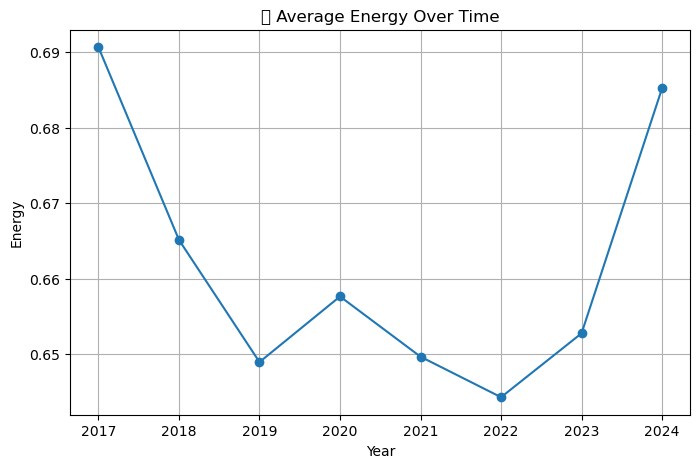

/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


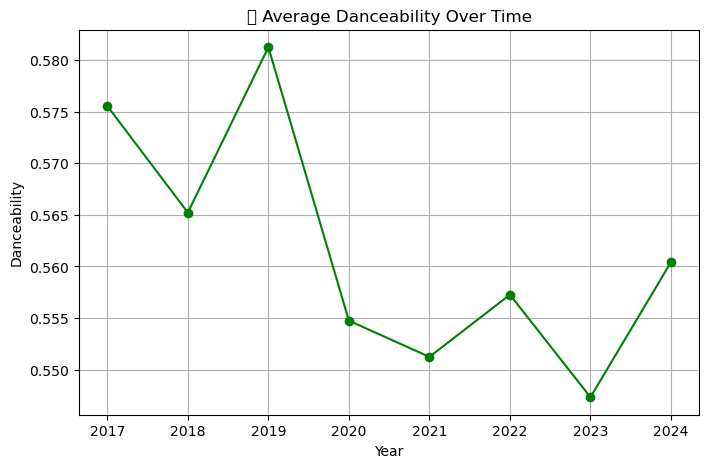

/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


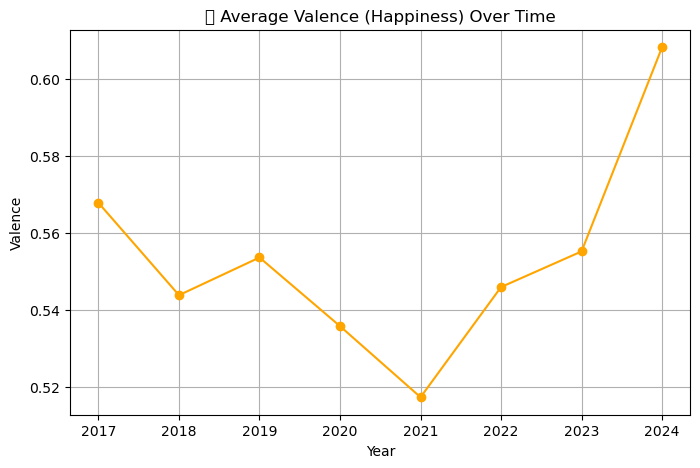

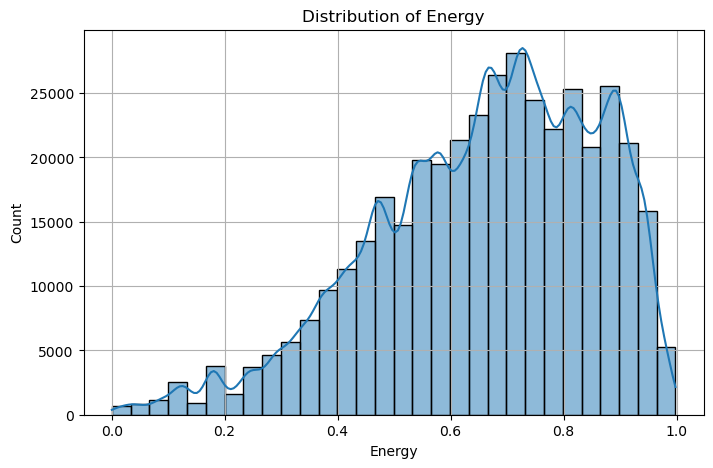

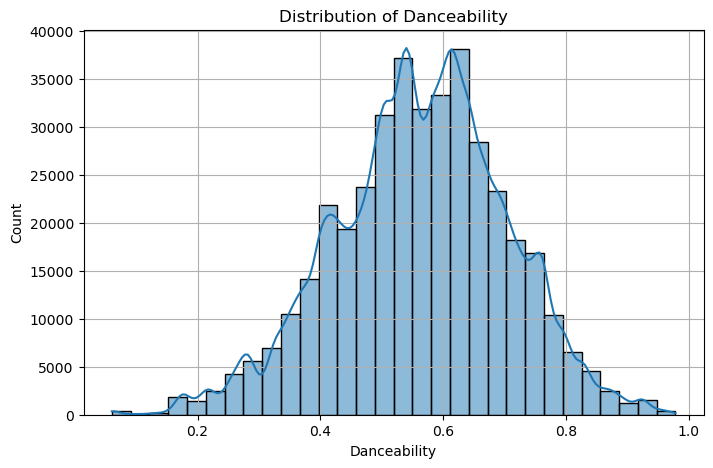

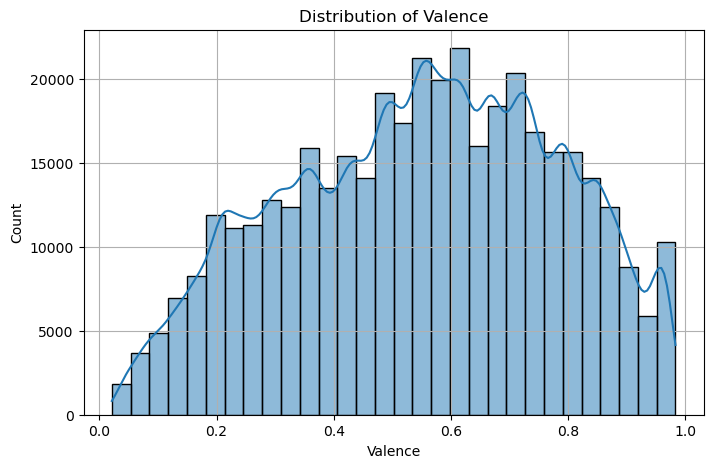

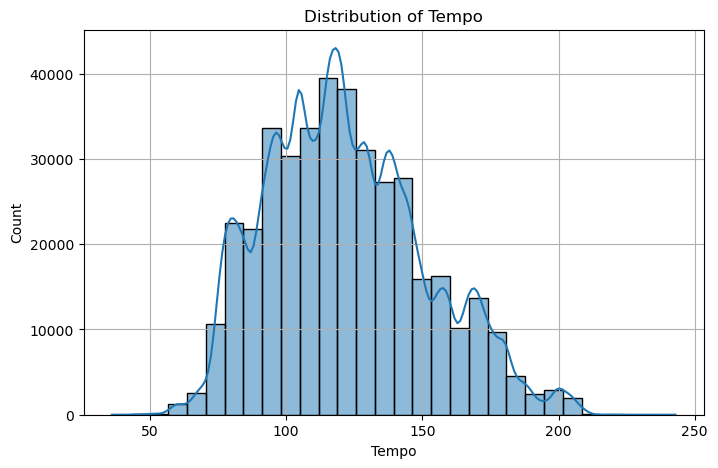

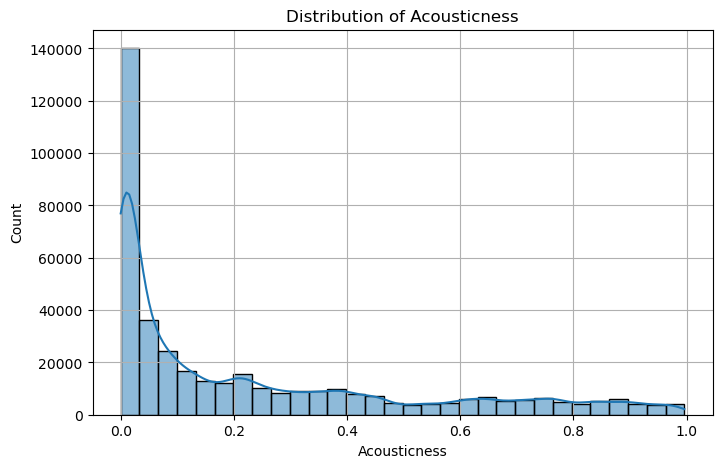

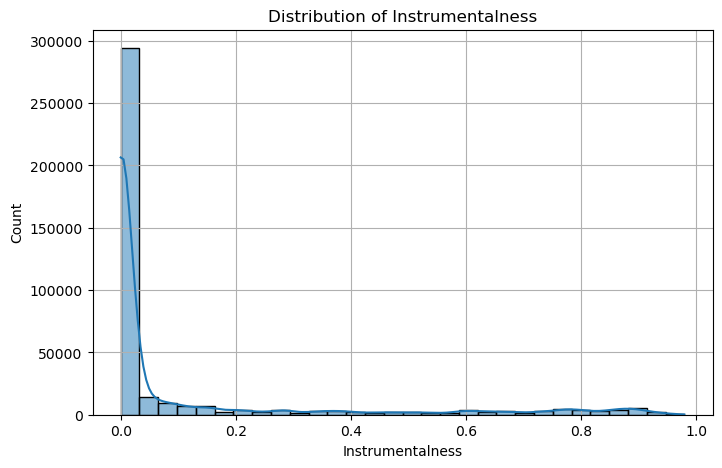

/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


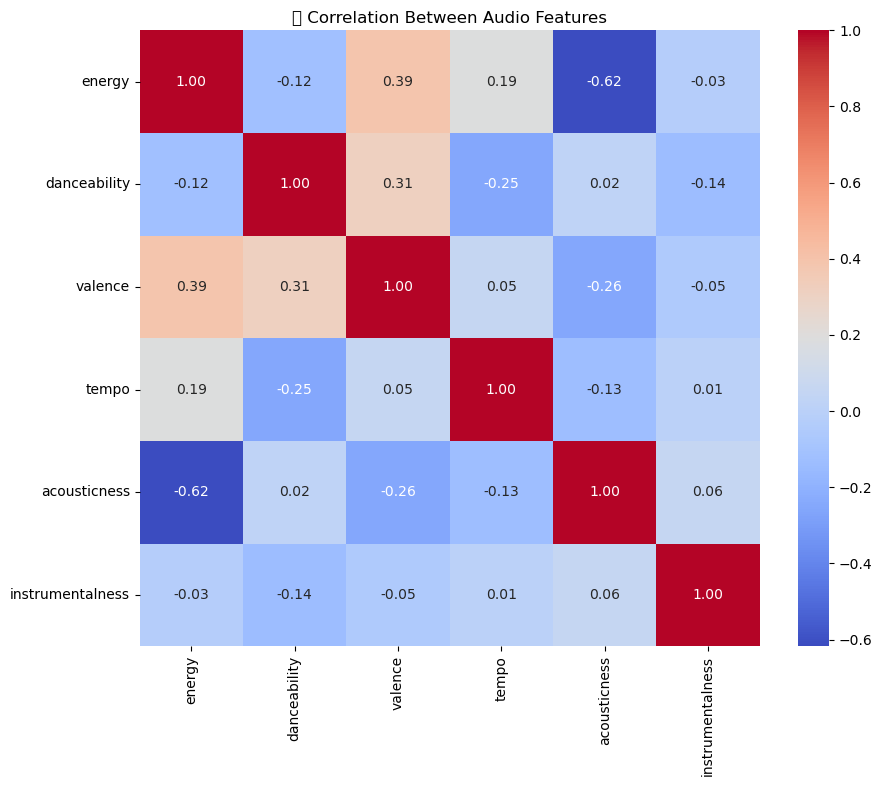

In [ ]:
# Load full streaming data and SpotifyFeatures ---
streaming_data = pd.read_csv('wrapped_data/streaming_data.csv')
spotify_features = pd.read_csv('wrapped_data/SpotifyFeatures.csv')

# Merge streaming history with audio features ---
data = pd.merge(
    streaming_data,
    spotify_features,
    how='inner',
    left_on=['master_metadata_track_name', 'master_metadata_album_artist_name'],
    right_on=['track_name', 'artist_name']
)

# Keep only data up to 2024 (2025 Wrapped timeframe is not complete)
data['ts'] = pd.to_datetime(data['ts'])
data = data[data['year'] <= 2024]

# Dataset overview 
print("Info:")
print(f"Shape of dataset: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\nMissing values:")
print(data.isnull().sum())

# Attribute Distributions

features = ['energy', 'danceability', 'valence', 'tempo', 'acousticness', 'instrumentalness']

print(" Basic Statistics for Audio Features:")
print(data[features].describe())

# Trends Over Time:

# Energy per year
energy_trend = data.groupby('year')['energy'].mean()

# Danceability per year
danceability_trend = data.groupby('year')['danceability'].mean()

# Valence (happiness) per year
valence_trend = data.groupby('year')['valence'].mean()

# Visualizations:

# Energy Trend
plt.figure(figsize=(8,5))
energy_trend.plot(marker='o')
plt.title('Average Energy Over Time')
plt.xlabel('Year')
plt.ylabel('Energy')
plt.grid(True)
plt.show()

# Danceability Trend
plt.figure(figsize=(8,5))
danceability_trend.plot(marker='o', color='green')
plt.title('Average Danceability Over Time')
plt.xlabel('Year')
plt.ylabel('Danceability')
plt.grid(True)
plt.show()

# Valence Trend
plt.figure(figsize=(8,5))
valence_trend.plot(marker='o', color='orange')
plt.title('Average Valence (Happiness) Over Time')
plt.xlabel('Year')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

# Distribution plots
for feature in features:
    plt.figure(figsize=(8,5))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature.capitalize()}')  
    plt.xlabel(feature.capitalize())
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

# Correlation Matrix
plt.figure(figsize=(10,8))
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Audio Features')
plt.show()


In [ ]:
# Title: Yearly Boxplots of Key Audio Features

# Description:
# Creates boxplots of energy, danceability, and valence by year 
# to visualize the distribution, spread, and outliers of each feature 
# across different years in the streaming history dataset.


/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


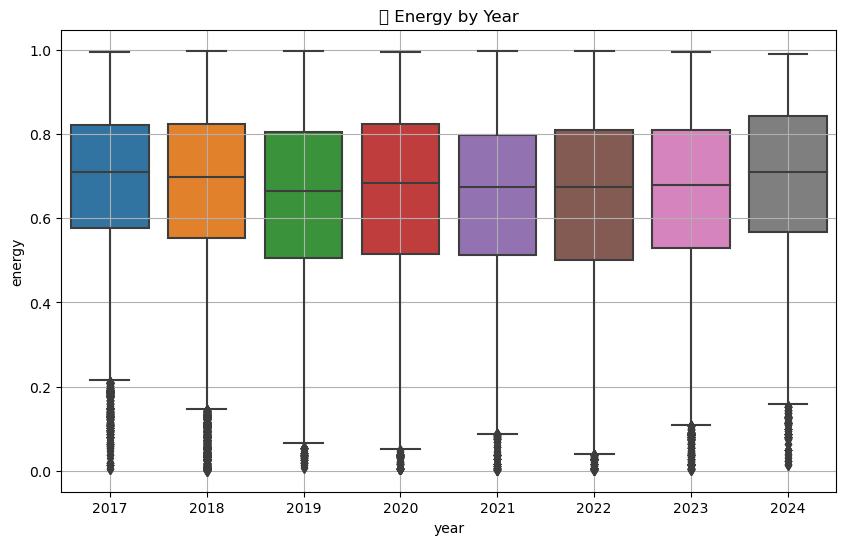

/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


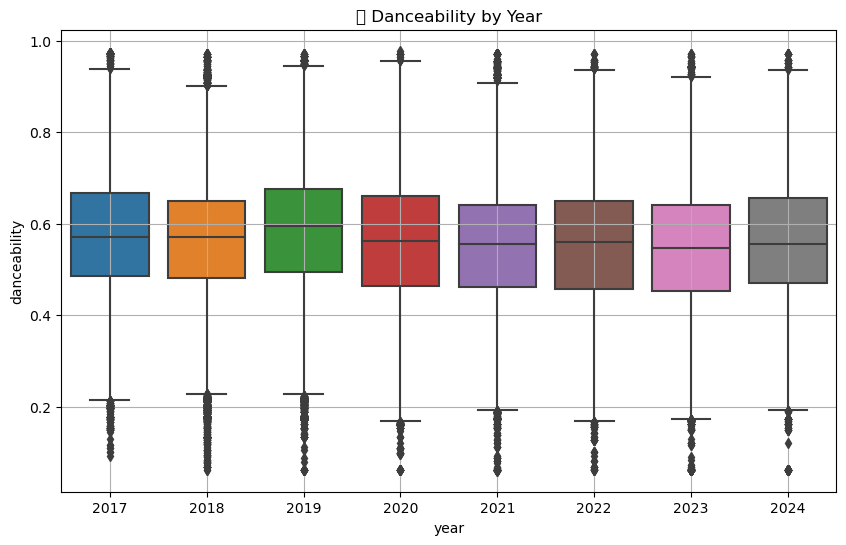

/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


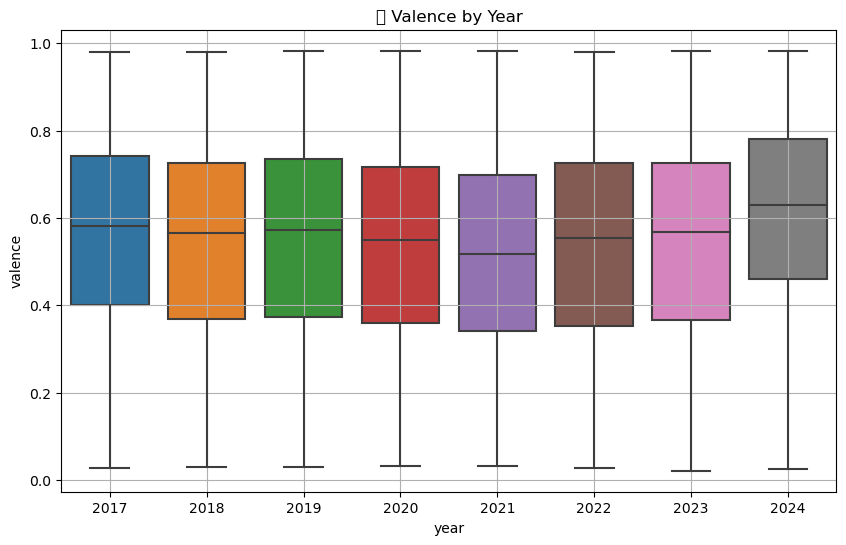

In [7]:
for feature in ['energy', 'danceability', 'valence']:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=data, x='year', y=feature)
    plt.title(f'🎵 {feature.capitalize()} by Year')
    plt.grid(True)
    plt.show()


In [ ]:
# Title: Energy Distribution by Top 10 Genres

# Description:
# Loads and merges Spotify streaming history with audio features and a preprocessed genre map, 
# assigns each artist a primary genre, 
# identifies the top 10 genres by total listening time (ms_played), 
# filters the dataset to include only these genres, 
# and visualizes the distribution of energy scores across genres using a boxplot.

/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


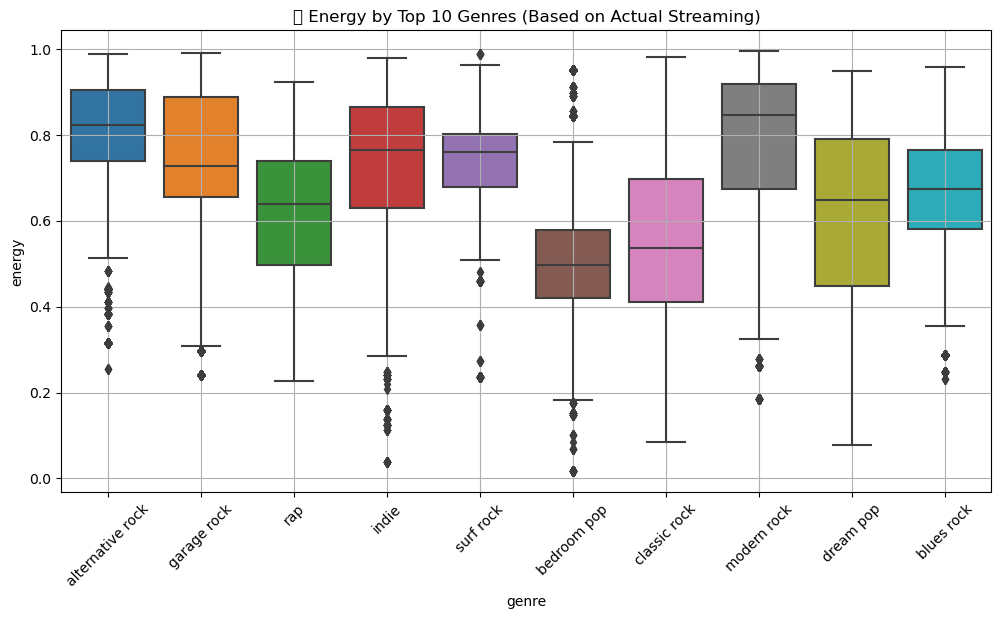

In [9]:


# Load full listening history
streaming_data = pd.read_csv('wrapped_data/streaming_data.csv')
spotify_features = pd.read_csv('wrapped_data/SpotifyFeatures.csv')

# Merge on track name + artist
merged = pd.merge(
    streaming_data,
    spotify_features,
    how='inner',
    left_on=['master_metadata_track_name', 'master_metadata_album_artist_name'],
    right_on=['track_name', 'artist_name']
)

# Load genre map
with open('wrapped_data/top_genres_clean.json', 'r') as f:
    genre_map = json.load(f)

# Map genre
merged['genre'] = merged['master_metadata_album_artist_name'].map(genre_map)
merged['genre'] = merged['genre'].apply(lambda g: g[0] if isinstance(g, list) else g)


# Top genres by ms_played
top_genres = (
    merged[merged['genre'].notnull()]
    .groupby('genre')['ms_played']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filter for plotting
filtered = merged[merged['genre'].isin(top_genres)]

# Plot energy by genre
plt.figure(figsize=(12,6))
sns.boxplot(data=filtered, x='genre', y='energy')
plt.xticks(rotation=45)
plt.title('🎵 Energy by Top 10 Genres (Based on Actual Streaming)')
plt.grid(True)
plt.show()


In [ ]:
# Title: Top 10 Songs by Energy, Danceability, and Valence

# Description:
# Sorts the merged streaming dataset by energy, danceability, and valence, 
# and prints the top 10 songs for each feature, 
# providing a quick look at the most energetic, danceable, and happiest songs 
# based on Spotify audio attributes.


In [ ]:
print("Top 10 Most Energetic Songs:")
print(data[['master_metadata_track_name', 'master_metadata_album_artist_name', 'energy']].sort_values(by='energy', ascending=False).head(10))

print("Top 10 Most Danceable Songs:")
print(data[['master_metadata_track_name', 'master_metadata_album_artist_name', 'danceability']].sort_values(by='danceability', ascending=False).head(10))

print("Top 10 Happiest Songs (Valence):")
print(data[['master_metadata_track_name', 'master_metadata_album_artist_name', 'valence']].sort_values(by='valence', ascending=False).head(10))



Top 10 Most Energetic Songs:
       master_metadata_track_name master_metadata_album_artist_name  energy
391551           Weapon Of Choice       Black Rebel Motorcycle Club   0.998
391550           Weapon Of Choice       Black Rebel Motorcycle Club   0.998
318624                        DVP                               PUP   0.998
365436                 West Coast                            FIDLAR   0.998
391549           Weapon Of Choice       Black Rebel Motorcycle Club   0.998
318622                        DVP                               PUP   0.998
365437                 West Coast                            FIDLAR   0.998
318623                        DVP                               PUP   0.998
268579       My Son Optimus Prime                         Dane Cook   0.997
268569                      Intro                         Dane Cook   0.997

Top 10 Most Danceable Songs:
       master_metadata_track_name master_metadata_album_artist_name  \
242726               Ice Ice Baby

In [ ]:
# Title: Spotify Wrapped Interactive Dashboard with Dash

# Description:
# Loads full streaming history and preprocessed vibe clusters, 
# initializes a Dash web app for interactive exploration of Spotify audio features, 
# includes dropdowns to visualize feature trends over time, 
# display top 10 songs by selected features in a table, 
# and plot 2D scatter clusters using selected feature pairs, 
# with hover details showing track and artist names.


In [ ]:

# Load and prepare data 
df = load_full_wrapped_data()
df = create_vibe_clusters(df)

# Feature list
features = ['energy', 'danceability', 'valence', 'tempo', 'acousticness', 'instrumentalness']

# Setup Dash
app = dash.Dash(__name__)
app.title = "Spotify Wrapped EDA"

app.layout = html.Div([
    html.H1("🎧 Spotify Wrapped EDA Dashboard", style={'textAlign': 'center'}),

    html.Div([
        dcc.Dropdown(
            id="feature-dropdown",
            options=[{"label": f.capitalize(), "value": f} for f in features],
            value="energy",
            clearable=False
        )
    ], style={"width": "50%", "margin": "auto"}),

    dcc.Graph(id="feature-trend"),

    html.H2("🎶 Top 10 Songs by Feature", style={'textAlign': 'center'}),
    dcc.Dropdown(
        id="top-feature-dropdown",
        options=[{"label": f.capitalize(), "value": f} for f in features],
        value="energy",
        clearable=False
    ),
    dash_table.DataTable(id="top-10-table", style_table={"overflowX": "auto"}),

    html.H2("🎨 Vibe Clusters", style={'textAlign': 'center'}),
    html.Div([
        dcc.Dropdown(
            id='x-axis-dropdown',
            options=[{'label': f.capitalize(), 'value': f} for f in features],
            value='energy',
            clearable=False,
            style={'width': '45%', 'display': 'inline-block', 'marginRight': '5%'}
        ),
        dcc.Dropdown(
            id='y-axis-dropdown',
            options=[{'label': f.capitalize(), 'value': f} for f in features],
            value='danceability',
            clearable=False,
            style={'width': '45%', 'display': 'inline-block'}
        )
    ], style={"width": "80%", "margin": "auto"}),
    dcc.Graph(id="cluster-plot")
])

# Callbacks using imported functions 

@app.callback(
    Output("feature-trend", "figure"),
    Input("feature-dropdown", "value")
)
def update_trend_plot(selected_feature):
    return generate_feature_trend(df, selected_feature)

@app.callback(
    Output("top-10-table", "data"),
    Input("top-feature-dropdown", "value")
)
def update_top_10_table(selected_feature):
    return generate_top_10_table(df, selected_feature)

@app.callback(
    Output("cluster-plot", "figure"),
    Input("x-axis-dropdown", "value"),
    Input("y-axis-dropdown", "value")
)
def update_cluster_plot(x_feature, y_feature):
    return px.scatter(
        df, x=x_feature, y=y_feature, color='vibe_cluster',
        hover_data=['master_metadata_track_name', 'master_metadata_album_artist_name'],
        title=f"Vibe Clustering ({x_feature.capitalize()} vs {y_feature.capitalize()})"
    )

# Run 
if __name__ == "__main__":
    app.run_server(debug=True)


/Users/adrianrodriguez/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
